# Анализ мобильной игры

## Задачи проекта

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

1. В первую очередь, его интересует показатель Retention. Напишите функцию для его подсчета.
2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

## Описание данных

Таблица ***reg_data*** - данные о времени регистрации:
- `reg_ts` - время регистрации;  
- `uid` - уникальный номер пользователя игры.

Таблица ***auth_data*** - данные о времени захода пользователей в игру:
- `auth_ts` - время, когда пользователь авторизовался в игре;
- `uid` - уникальный номер пользователя игры.

Таблица ***ab_test_result*** - результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667:
- `user_id` - ID пользователя;
- `revenue` - выручка, полученная от пользователя;
- `testgroup` - группа, к которой принадлежит пользователь (А или B).

## Загрузка данных

In [1]:
import pandas as pd
import requests
from urllib.parse import urlencode
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

In [2]:
reg_data = pd.read_csv(
    '/mnt/HC_Volume_18315164/home-jupyter/jupyter-vladimir-kosenkov--906f3/shared/problem1-reg_data.csv',
                      sep=';')
auth_data = pd.read_csv(
    '/mnt/HC_Volume_18315164/home-jupyter/jupyter-vladimir-kosenkov--906f3/shared/problem1-auth_data.csv',
                        sep=';')

# Загружаем датасеты по ссылке на яндекс диске
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

# Ссылки на наши датасеты на яндекс диске
public_key1 = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'

# Получаем загрузочные ссылки
final_url1 = base_url + urlencode(dict(public_key = public_key1))

response1 = requests.get(final_url1)

download_url1 = response1.json()['href']

# Загружаем файлы в df 
download_response1 = requests.get(download_url1) 

ab_test_result = pd.read_csv(download_url1, sep=";")

In [3]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [5]:
reg_data.describe()

,reg_ts,uid
count,1.000000e+06,1.000000e+06
mean,1.548332e+09,5.552354e+05
std,5.253653e+07,3.206011e+05
min,9.113822e+08,1.000000e+00
25%,1.528034e+09,2.776438e+05
50%,1.564454e+09,5.550455e+05
75%,1.585759e+09,8.329712e+05
max,1.600874e+09,1.110622e+06


In [6]:
reg_data.uid.nunique()

1000000

В таблице reg_data все пользователи уникальные, нет задвоения. Время регистрации указано в секундах, стоит создать новое поле с соответсвующим форматом.

In [7]:
reg_data['registration_date'] = pd.to_datetime(reg_data.reg_ts, unit='s')
reg_data.tail()

,reg_ts,uid,registration_date
999995,1600874034,1110618,2020-09-23 15:13:54
999996,1600874086,1110619,2020-09-23 15:14:46
999997,1600874139,1110620,2020-09-23 15:15:39
999998,1600874191,1110621,2020-09-23 15:16:31
999999,1600874244,1110622,2020-09-23 15:17:24


In [8]:
reg_data.registration_date.describe(datetime_is_numeric=True)

count                          1000000
mean     2019-01-24 12:12:34.523666688
min                1998-11-18 09:43:43
25%         2018-06-03 13:55:11.500000
50%                2019-07-30 02:35:25
75%         2020-04-01 16:28:40.500000
max                2020-09-23 15:17:24
Name: registration_date, dtype: object

Видим, что первая дата регистрации была в 1998 году, а последняя 23 сентября 2020 года.

In [9]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [10]:
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [11]:
auth_data.describe()

,auth_ts,uid
count,9.601013e+06,9.601013e+06
mean,1.548778e+09,3.347198e+05
std,5.160527e+07,2.832669e+05
min,9.113822e+08,1.000000e+00
25%,1.528375e+09,9.599700e+04
50%,1.564577e+09,2.579210e+05
75%,1.585823e+09,5.190250e+05
max,1.600874e+09,1.110622e+06


In [12]:
auth_data.duplicated().sum()

0

В таблице auth_data нет дубликатов, все авторизации уникальные. Время авторизации указано в секундах, стоит создать новое поле с соответсвующим форматом.

In [13]:
auth_data['authorization_date'] = pd.to_datetime(auth_data.auth_ts, unit='s')
auth_data.tail()

,auth_ts,uid,authorization_date
9601008,1600874034,1110618,2020-09-23 15:13:54
9601009,1600874086,1110619,2020-09-23 15:14:46
9601010,1600874139,1110620,2020-09-23 15:15:39
9601011,1600874191,1110621,2020-09-23 15:16:31
9601012,1600874244,1110622,2020-09-23 15:17:24


In [14]:
auth_data.authorization_date.describe(datetime_is_numeric=True)

count                          9601013
mean     2019-01-29 16:12:06.254851584
min                1998-11-18 09:43:43
25%                2018-06-07 12:40:47
50%                2019-07-31 12:43:16
75%                2020-04-02 10:25:21
max                2020-09-23 15:17:24
Name: authorization_date, dtype: object

Также первая авторизация произошла в 1998 году, и последняя 23 сентября 2020 года.

In [15]:
ab_test_result.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [16]:
ab_test_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [17]:
ab_test_result.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


In [18]:
ab_test_result.duplicated().sum()

0

Дубликаты в таблице ab_test_result отсутствуют. В целом данные выглядят подготовленными и готовыми к анализу.

### 1. Retention пользователей

Функция, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [19]:
def visualization_daily_retention(reg_data, auth_data, start_date, days):
    
    """    Функция считает retention по дням от даты регистрации, на вход подаются два    
    датафрейма с регистрацией и авторизацией, дата, с которой нужно считать retention, и     
    количество дней. На выходе строится тепловая карта retention по дням.
    """
    
    start_date = pd.to_datetime(start_date)
    end_date = start_date + pd.Timedelta(days=days)
    
    reg_data['registration_date'] = pd.to_datetime(reg_data.reg_ts, unit='s').dt.floor('D')
    auth_data['authorization_date'] = pd.to_datetime(auth_data.auth_ts, unit='s').dt.floor('D')
    
    # фильтруем заранее перед мерджем для лучшей оптимизации запроса
    reg_data = reg_data.query('registration_date >= @start_date')
    auth_data = auth_data.query('authorization_date <= @end_date')
    reg_auth_data = reg_data.merge(auth_data, on='uid')
    
        
    df_cohort = reg_auth_data.groupby(['registration_date', 'authorization_date'], as_index=False) \
                             .agg(users=('uid', 'nunique'))
    
    df_cohort['day_delta'] = (df_cohort['authorization_date'] - df_cohort['registration_date']).dt.days
    
    cohort_pivot = df_cohort.pivot_table(index='registration_date', columns='day_delta', values='users')
    cohort_size = cohort_pivot.iloc[:, 0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
    
    # Уберем нулевой день для лучшей визуализации
    retention_matrix = retention_matrix.drop(columns=[0], errors='ignore')
    
    with sns.axes_style('white'):
        fig, ax = plt.subplots(1, 2, figsize=(20, 12), sharey=True, gridspec_kw={'width_ratios': [1, 30]})

        # тепловая карта для коэффициентов удержания
        sns.heatmap(
            retention_matrix,
            mask=retention_matrix.isnull(),
            annot=True,
            fmt=".2%",
            cmap="viridis",
            vmin=0.0,
            vmax=retention_matrix.max().max(),
            ax=ax[1]
        )
        ax[1].set_title('Daily Retention', fontsize=16)
        ax[1].set(xlabel='№ периода', ylabel='Когорта')
        
        

        # тепловая карта для размеров когорт
        cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'Размер когорты'})
        white_cmap = mcolors.ListedColormap(['white'])
        sns.heatmap(cohort_size_df,
                   annot = True, 
                   cbar=False,
                   fmt = 'g',
                   cmap=white_cmap,
                   ax=ax[0])
        ax[0].set_ylabel("Дата регистрации", fontsize=12)
        ax[0].set_yticklabels(retention_matrix.index.strftime('%Y-%m-%d'), fontsize=10)

        fig.tight_layout()
        plt.show()

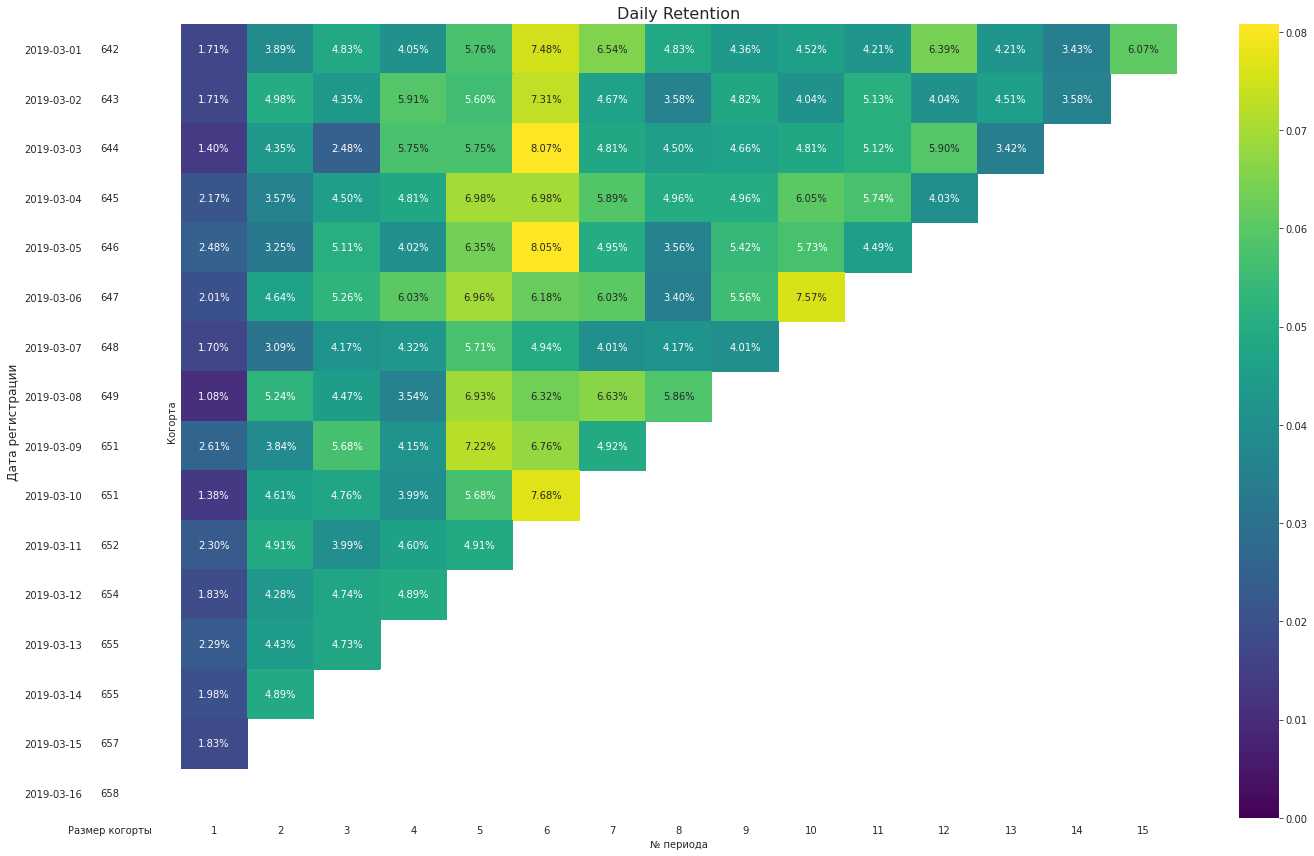

In [20]:
# проверка работы функции
date = '2019-03-01'
number_of_days = 15
visualization_daily_retention(reg_data, auth_data, date, number_of_days)

## 2. Анализ A/B теста.

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Контрольная группа А, тестовая В. 

In [21]:
# проверим условие, соответствует ли количество платящих пользователей по группам
# а также посмотрим на конверсию в платящего пользователя по группам
df_group = (
    ab_test_result.query('revenue > 0')
    .groupby('testgroup', as_index=False)
    .agg(paying_users=('user_id', 'count'))
    .merge(
        ab_test_result.groupby('testgroup', as_index=False).agg(count_users=('user_id', 'count')),
        on='testgroup'
    )
    .assign(conv_paying_users=lambda x: x.paying_users / x.count_users)
)
df_group.style.format({
    'conv_paying_users': '{:,.2%}'.format
})

,testgroup,paying_users,count_users,conv_paying_users
0,a,1928,202103,0.95%
1,b,1805,202667,0.89%


***Конверсия в платящего пользователя(Conversion Rate)*** составляет чуть менее 1% в обоих группах. Разница в конверсиях 0.06%. Проверим стат. значимость с использованием **Хи квадрат теста**.

H0: Конверсии в платящих пользователей стат. значимо не отличаются.

H1: Конверсии в платящих пользователей различаются между группами.

In [22]:
chi_table = np.array(
    [
        [df_group.paying_users[0], df_group.count_users[0] - df_group.paying_users[0]],  # A: оплатили, не оплатили
        [df_group.paying_users[1], df_group.count_users[1] - df_group.paying_users[1]]   # B: оплатили, не оплатили
    ]
)
# χ²-тест
chi2, p_value, dof, expected = chi2_contingency(chi_table)

alpha = 0.05

print(f"P-value: {p_value:.4f}")

if p_value < alpha:
    print("Отклоняем нулевую гипотезу: конверсии в платящих пользователей стат.значимо различаются между группами.")
else:
    print("Не можем отклонить нулевую гипотезу: конверсии в платящих пользователей стат. значимо не отличаются.")

P-value: 0.0365
Отклоняем нулевую гипотезу: конверсии в платящих пользователей стат.значимо различаются между группами.


In [23]:
# сделаем два датафрейма, где будут лежать юзеры по своим группам
a_group = ab_test_result.query('testgroup == "a"')
b_group = ab_test_result.query('testgroup == "b"')

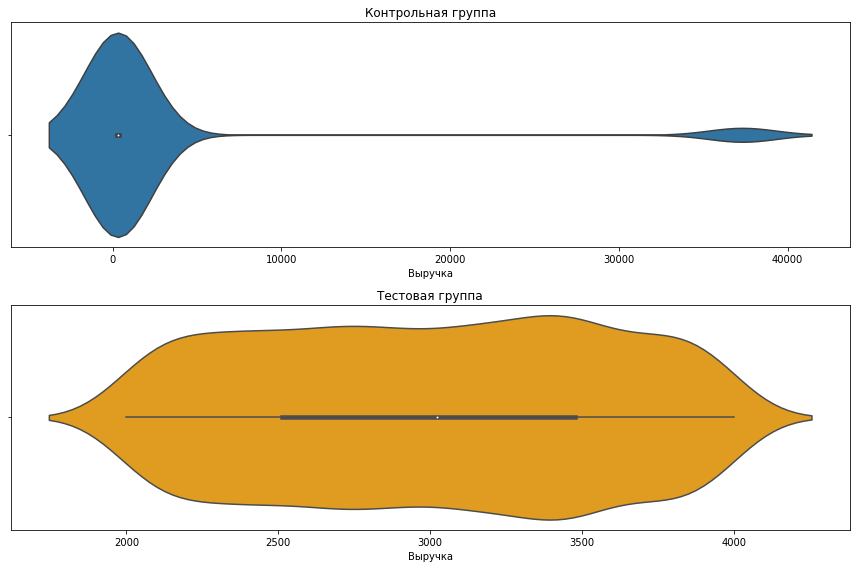

In [24]:
# посмотрим на распределение выручки в обоих группах
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
sns.violinplot(data=a_group.query('revenue > 0'), x='revenue', ax=ax[0])
ax[0].set_xlabel('Выручка')
ax[0].set_title('Контрольная группа')

sns.violinplot(data=b_group.query('revenue>0'), x='revenue', ax=ax[1], color = 'orange')
ax[1].set_xlabel('Выручка')
ax[1].set_title('Тестовая группа')
fig.tight_layout()
plt.show()

Посмотрим детальнее на контрольную группу, где разброс выручки больше.

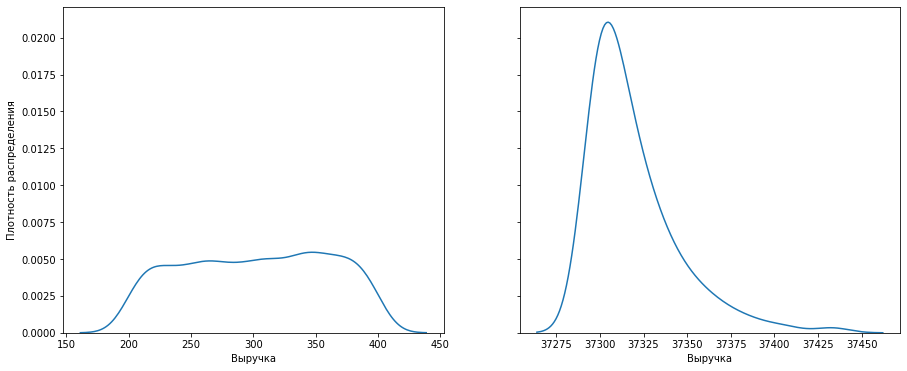

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

sns.kdeplot(data=a_group.query('revenue<1000 & revenue>0'), x="revenue", ax=ax[0])
ax[0].set_xlabel('Выручка')
ax[0].set_ylabel('Плотность распределения')
sns.kdeplot(data=a_group.query('revenue>1000'), x="revenue", ax=ax[1])
ax[1].set_xlabel('Выручка')
plt.show()

In [26]:
count_paying_users = a_group.query('revenue>1000').revenue.count()
perc_big_pay = (
    a_group.query('revenue > 1000').revenue.count() / a_group.query('revenue > 0').revenue.count()
) 
print(f'Количество пользователей, выручка которых более 37000 у.е.: {count_paying_users} человека')
print(f'Процент крупных платежей в контрольной группе: {round(perc_big_pay, 3)}')

Количество пользователей, выручка которых более 37000 у.е.: 123 человека
Процент крупных платежей в контрольной группе: 0.064


In [27]:
# стандартное отклонение в двух группах 
print(f"Стандартное отклонение в группе А: {round(np.std(a_group.query('revenue>0').revenue),2)}")
print(f"Стандартное отклонение в группе B: {round(np.std(b_group.query('revenue>0').revenue), 2)}")

Стандартное отклонение в группе А: 9046.69
Стандартное отклонение в группе B: 572.46


**ARPU/ARPPU**

In [28]:
print(f'Средний чек в контрольной группе составляет: {round(a_group.revenue.mean(), 2)}')

Средний чек в контрольной группе составляет: 25.41


In [29]:
print(f'Средний чек в тестовой группе составляет: {round(b_group.revenue.mean(), 2)}')

Средний чек в тестовой группе составляет: 26.75


In [30]:
a_group.query('revenue>0').revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [31]:
b_group.query('revenue>0').revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

Проведем **t-тест с критерием Уэлча** для определения есть ли стат. значимая разница между ***ARPU*** в группах, так как данные распределены в группе А с выбросом.

H0: Средний чек между группами стат. значимо не отличается.

H1: Средний чек имеет стат. значимое отличие между группами.

In [32]:
# Выполнение t-теста с критерием Уэлча
t_stat, p_value = ttest_ind(a_group.revenue, b_group.revenue, equal_var=False)

print(f"T-статистика: {t_stat}")

alpha = 0.05

print(f"P-value: {p_value:.4f}")

if p_value < alpha:
    print("Отклоняем нулевую гипотезу: средний чек различается между группами.")
else:
    print("Не можем отклонить нулевую гипотезу: средний чек стат. значимо не отличается.")

T-статистика: -0.6234876562792212
P-value: 0.5330
Не можем отклонить нулевую гипотезу: средний чек стат. значимо не отличается.


t-тест с критерием Уэлча показал, что нет стат. значимой разницы между ARPU в группах.

Для определения стат. значимой разницы между ***ARPPU*** в группах будем использвать **bootstrap**, так как количество полей существенно меньше, а данный способ требует больше вычислительных ресурсов, а также данный метод не зависим от распределения выборок.  

H0: Средний чек платящих пользователей стат. значимо не отличается.

H1: Средний чек платящих пользователей различается между группами.

In [33]:
# Функция для bootstrap
def bootstrap_median_diff(data1, data2, n_bootstraps=10000):
    median_diffs = []
    for i in range(n_bootstraps):
        sample1 = np.random.choice(data1, size=len(data1), replace=True)
        sample2 = np.random.choice(data2, size=len(data2), replace=True)
        median_diffs.append(np.median(sample2) - np.median(sample1))
    return median_diffs


# Ресемплирование
median_diffs = bootstrap_median_diff(a_group.query('revenue>0').revenue, b_group.query('revenue>0').revenue)

real_diff = np.median(b_group.query('revenue>0').revenue) - np.median(a_group.query('revenue>0').revenue)
p_value = (np.abs(median_diffs) >= np.abs(real_diff)).mean()

alpha = 0.05

print(f"P-value: {p_value:.4f}")

if p_value < alpha:
    print("Отклоняем нулевую гипотезу: средний чек платящего пользователя различается между группами.")
else:
    print("Не можем отклонить нулевую гипотезу: средний чек платящего пользователя стат. значимо не отличается.")

P-value: 0.4988
Не можем отклонить нулевую гипотезу: средний чек платящего пользователя стат. значимо не отличается.


Bootstrap показал, что нет стат. значимой разницы между ARPPU в группах.

**Gross Revenue**

In [34]:
print(f'Общая выручка в контрольной группе равна: {a_group.revenue.sum()}')
print(f'Общая выручка в тестовой группе равна: {b_group.revenue.sum()}')
print(f'Разница между выручками в двух группах: {(b_group.revenue.sum() - a_group.revenue.sum())}')

Общая выручка в контрольной группе равна: 5136189
Общая выручка в тестовой группе равна: 5421603
Разница между выручками в двух группах: 285414


### Выводы

В контрольной группе:

- **Общая выручка** - 5136189;
- ***Минимальный чек*** - 200;
- ***ARPU*** - 25.41;
- ***ARPPU*** - 2664;
- ***Максимальный чек*** - 37433;
- **Конверсия в платящего пользователя** - 0.95%.

В тестовой группе:

- **Общая выручка** - 5421603;
- ***Минимальный чек*** - 2000;
- ***ARPU*** - 26.75;
- ***ARPPU*** - 3003;
- ***Максимальный чек*** - 4000;
- **Конверсия в платящего пользователя** - 0.89%.

Используя χ²-тест определено, что конверсии в платящих пользователей стат.значимо различаются между группами. 

С помощью t-теста с критерием Уэлча разница между ARPU в группах стат. значимо не отличается.

Bootstrap показал, что нет стат. значимой разницы между ARPPU в группах.

Таким образом акционное предложение в **контрольной группе можно считать лучше** тестовой, так как конверсия в платящего пользователя выше, а также сохраняется потенциал для крупных платежей(6.4% пользователей делали крупные покупки).

Стоит сказать, что в А/B тест проведен неверно с учетом того, что в обеих группах неправильно произведено сплитование пользователей. В контрольной группе ARPU и ARPPU получает свои значения за счет 6.4% пользователей, которые совершили крупные покупки. Если пользователей разбить на 3 группы: с низким чеком, средним чеком и высоким, то в контрольную попали пользователи с низким и высоким, а в тестовую со средним.

А/В тест стоит перезапустить с надежным способом сплитования(случайное или стратифицированное), где будет указываться сегмент пользователей с низким, средним и высоким чеком.

## 3. Анализ игровых событий

1. В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?


2. Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?


### 3.1 Упрощенная механика

Рассмотрим метрики для структуры игры первого варианта.

**Метрики вовлеченности и удержания:**

1. DAU/MAU - так как событие проводятся каждый месяц, то стоит отслеживать активных пользователей по дням и по месяцам, повышение DAU будет говорить об успешности данной акции;
2. Retention - процент вернувшихся игроков означает насколько заинтересовало игроков данное событие;
3. Среднее количество пройденных уровней - покажет вовлеченность пользователей в получении награды, а также можно будет понимать какая оптимальная сложность игры. Стоит ли повысить сложность или понизить;
4. Средняя длительность сессии игры - если длительность увеличивается, то вовлеченность также увеличивается;
5. Качество уникальных предметов и персонажей, монет и бонусов может говорить о том, какие фичи больше нравятся игрокам и какие стоит чаще выдавать или стоит предлагать выбрать самим.
6. Churn rate - на каком уровне происходит наибольший отток пользователей.

**Метрики продукта:**

1. ARPU - показывает средний чек среди всех игроков;
2. ARPPU - показывает, средний чек среди всех платящих пользователей;
3. Сonversion Rate - конверсия в платящего пользователя, при ее повышении будет понимание, что механизмы монетизации игры идут в правильную сторону;
4. LTV - общая прибыль, которую принесет пользователь за все время использования продукта

### 3.2 Усложненная механика

Рассмотрим метрики для структуры игры второго варианта. Метрики для первого варианта будут актуальны для второго с небольшими поправками. Так как механика игры усложнится, то продуктовые метрики могут как повыситься, так и понизиться в зависимости от того насколько заинтересует пользователей сложность игры. Для того, чтобы следить за удовлетворенностью пользователей, стоит также проводить опросы, создать окно для жалоб, смотреть за позитивными и негативными отзывами в Store. 

**Метрики вовлеченности и удержания:**

1. Количество повторных попыток прохождений уровня - как часто игроки пытаются пройти уровень заново.
2. Churn rate - усложняющая механика может увеличить отток пользователей.
3. Самый сложный уровень(или наибольшая доля игроков, которые ушли на определенном уровне) - на каком уровне чаще всего игроки перестают играть.
4. Среднее количество попыток на прохождение уровня.

**Метрики продукта:**

1. Процент игроков, которые делают покупки, чтобы завершить уровень.
2. Доля игроков, которые смотрят рекламу или делают покупки для получение дополнительных монет.
